In [1]:
import json
import pandas as pd
from pathlib import Path
from pprint import pprint
import datetime
import time
import numpy as np
import matplotlib as plt

import pandas
import researchpy as rp
import seaborn as sns

import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.multicomp

%matplotlib inline

In [2]:
#path_results = Path('/media/discoD/models/elmo/ner/results_20_epochs_ibm')
#path_results = Path('/media/discoD/models/elmo/ner/results_1_epoch_harem_all_combinations')
path_results = Path('/media/discoD/models/elmo/ner/mestrado/results_dgx1/')

In [3]:
for folder in path_results.iterdir():
    print(folder)

/media/discoD/models/elmo/ner/mestrado/results_dgx1/harem-ft1epoch_ELMo
/media/discoD/models/elmo/ner/mestrado/results_dgx1/harem-ft1epoch_ELMo+CNN
/media/discoD/models/elmo/ner/mestrado/results_dgx1/harem-ft1epoch_ELMo+CNN+Embeddings
/media/discoD/models/elmo/ner/mestrado/results_dgx1/harem-ft1epoch_ELMo+Embeddings
/media/discoD/models/elmo/ner/mestrado/results_dgx1/harem-ft_ELMo
/media/discoD/models/elmo/ner/mestrado/results_dgx1/harem-ft_ELMo+CNN
/media/discoD/models/elmo/ner/mestrado/results_dgx1/harem-ft_ELMo+CNN+Embeddings
/media/discoD/models/elmo/ner/mestrado/results_dgx1/harem-ft_ELMo+Embeddings
/media/discoD/models/elmo/ner/mestrado/results_dgx1/harem-wikibrwac-ft_ELMo
/media/discoD/models/elmo/ner/mestrado/results_dgx1/harem-wikibrwac-ft_ELMo+CNN
/media/discoD/models/elmo/ner/mestrado/results_dgx1/harem-wikibrwac-ft_ELMo+CNN+Embeddings
/media/discoD/models/elmo/ner/mestrado/results_dgx1/harem-wikibrwac-ft_ELMo+Embeddings
/media/discoD/models/elmo/ner/mestrado/results_dgx1/ha

In [4]:
configs = dict()
metrics = dict()
for model_folder in path_results.iterdir():
    if 'Embeddings' in model_folder.name:
        #print('Reading embeddings folder from %s' % model_folder.name)
        for embedding_folder in model_folder.iterdir():
            #print('Reading trainings folder from %s' % embedding_folder.name)
            for training_folder in embedding_folder.iterdir():
                key = embedding_folder.name + '_' + training_folder.name
                #print('Reading files from %s' % key)
                has_metrics = False
                for results_file in training_folder.iterdir():
                    if results_file.name.endswith('.json'):
                        #print('Parsing data from %s' % results_file.name)
                        if results_file.name.startswith('config'):
                            configs[key] = json.loads(results_file.read_bytes())
                        elif results_file.name.startswith('metrics.'):
                            metrics[key] = json.loads(results_file.read_bytes())
                            has_metrics = True
                if not has_metrics:
                    print('metrics.json not found for %s' % key)
                    del configs[key]
    else:
        #print('Reading trainings folder from %s' % model_folder.name)
        for training_folder in model_folder.iterdir():
            key = training_folder.name
            #print('Reading files from %s' % key)
            has_metrics = False
            for results_file in training_folder.iterdir():
                if results_file.name.endswith('.json'):
                    #print('Parsing data from %s' % results_file.name)
                    if results_file.name.startswith('config'):
                        configs[key] = json.loads(results_file.read_bytes())
                    elif results_file.name.startswith('metrics.'):
                        metrics[key] = json.loads(results_file.read_bytes())
                        has_metrics = True
            if not has_metrics:
                print('metrics.json not found for %s' % key)
                del configs[key]
print(len(metrics))
print(len(configs))

metrics.json not found for harem_ELMo+Embeddings_wang2vec_cbow_3_4
3451
3451


In [5]:
def get_seconds(time_str):
    x = time.strptime(time_str.split('.')[0],'%H:%M:%S')
    return datetime.timedelta(hours=x.tm_hour,minutes=x.tm_min,seconds=x.tm_sec).total_seconds()
def get_average_epoch_duration(metrics):
    seconds = get_seconds(metrics['training_duration'])
    training_epochs = metrics['training_epochs'] + 1
    return seconds / training_epochs

In [6]:
TRAINING_ID = 'Training_ID'
SCENARIO = 'Scenario'
MODEL = 'Model'
REPRESENTATION = 'Representation'
EMBEDDING = 'Embedding'
EMBEDDING_TYPE = 'Embedding_Type'
BATCH_SIZE = 'Batch_Size'
ELMO_DROPOUT = 'ELMo_Dropout'
TRAINING_NUMBER = 'Training_Number'
EXECUTION_NUMBER = 'Execution_Number'
BEST_EPOCH = 'Best_Epoch'
TRAINING_EPOCHS = 'Training_Epochs'
TRAINING_DURATION = 'Training_Duration'
TOTAL_DURATION = 'Total_Duration(s)'
AVERAGE_EPOCH_DURATION = 'Average_Epoch_Duration(s)'
TRAINING_ACCURACY = 'Training_Accuracy'
TRAINING_ACCURACY_TOP3 = 'Training_Accuracy_Top-3'
TRAINING_PRECISION = 'Training_Precision'
TRAINING_RECALL = 'Training_Recall'
TRAINING_F1_MEASURE = 'Training_F1-Measure'
TRAINING_LOSS = 'Training_Loss'
BEST_VALIDATION_ACCURACY = 'Best_Validation_Accuracy'
BEST_VALIDATION_ACCURACY_TOP3 = 'Best_Validation_Accuracy_Top-3'
BEST_VALIDATION_PRECISION = 'Best_Validation_Precision'
BEST_VALIDATION_RECALL = 'Best_Validation_Recall'
BEST_VALIDATION_F1_MEASURE = 'Best_Validation_F1-Measure'
BEST_VALIDATION_LOSS = 'Best_Validation_Loss'
TEST_ACCURACY = 'Test_Accuracy'
TEST_ACCURACY_TOP3 = 'Test_Accuracy_Top-3'
TEST_PRECISION = 'Test_Precision'
TEST_RECALL = 'Test_Recall'
TEST_F1_MEASURE = 'Test_F1_Measure'
TEST_LOSS = 'Test_Loss'
columns = [TRAINING_ID, MODEL, REPRESENTATION, EMBEDDING, EMBEDDING_TYPE, TRAINING_NUMBER, EXECUTION_NUMBER, BEST_EPOCH, TRAINING_EPOCHS, TRAINING_DURATION, TOTAL_DURATION, AVERAGE_EPOCH_DURATION, TRAINING_ACCURACY, TRAINING_ACCURACY_TOP3, TRAINING_PRECISION, TRAINING_RECALL, TRAINING_F1_MEASURE, TRAINING_LOSS, BEST_VALIDATION_ACCURACY, BEST_VALIDATION_ACCURACY_TOP3, BEST_VALIDATION_PRECISION, BEST_VALIDATION_RECALL, BEST_VALIDATION_F1_MEASURE, BEST_VALIDATION_LOSS, TEST_ACCURACY, TEST_ACCURACY_TOP3, TEST_PRECISION, TEST_RECALL, TEST_F1_MEASURE, TEST_LOSS]
columns

['Training_ID',
 'Model',
 'Representation',
 'Embedding',
 'Embedding_Type',
 'Training_Number',
 'Execution_Number',
 'Best_Epoch',
 'Training_Epochs',
 'Training_Duration',
 'Total_Duration(s)',
 'Average_Epoch_Duration(s)',
 'Training_Accuracy',
 'Training_Accuracy_Top-3',
 'Training_Precision',
 'Training_Recall',
 'Training_F1-Measure',
 'Training_Loss',
 'Best_Validation_Accuracy',
 'Best_Validation_Accuracy_Top-3',
 'Best_Validation_Precision',
 'Best_Validation_Recall',
 'Best_Validation_F1-Measure',
 'Best_Validation_Loss',
 'Test_Accuracy',
 'Test_Accuracy_Top-3',
 'Test_Precision',
 'Test_Recall',
 'Test_F1_Measure',
 'Test_Loss']

In [7]:
def get_training_data_from_id(training_id, config):
    data = training_id.split('_')
    print(data)
    if len(data) == 4:
        return {MODEL: data[0], REPRESENTATION: data[1], EMBEDDING: 'No', EMBEDDING_TYPE: 'No', TRAINING_NUMBER: data[2], EXECUTION_NUMBER: data[3]}
    elif len(data) == 5:
        #GloVe
        return {MODEL: data[0], REPRESENTATION: data[1], EMBEDDING: data[2], EMBEDDING_TYPE: 'No', TRAINING_NUMBER: data[3], EXECUTION_NUMBER: data[4]}
    elif len(data) == 6:
        embedding_type = data[3] if data[2] != 'glove' else 'No'
        return {MODEL: data[0], REPRESENTATION: data[1], EMBEDDING: data[2], EMBEDDING_TYPE: embedding_type, TRAINING_NUMBER: data[4], EXECUTION_NUMBER: data[5]}
    else:
        print('Check id: %s' % training_id)

In [8]:
training_data = []
for training_id, config in configs.items():
    training_metrics = metrics[training_id]
    data = get_training_data_from_id(training_id, config)
    data[TRAINING_ID] = training_id
    data[BEST_EPOCH] = training_metrics['best_epoch'] if training_metrics else None
    data[TRAINING_EPOCHS] = training_metrics['training_epochs'] + 1 if training_metrics else None
    data[TRAINING_DURATION] = training_metrics['training_duration'] if training_metrics else None
    data[TOTAL_DURATION] = get_seconds(training_metrics['training_duration']) if training_metrics else None
    data[AVERAGE_EPOCH_DURATION] = get_average_epoch_duration(training_metrics) if training_metrics else None
    data[TRAINING_ACCURACY] = training_metrics['training_accuracy'] if training_metrics else None
    data[TRAINING_ACCURACY_TOP3] = training_metrics['training_accuracy3'] if training_metrics else None
    data[TRAINING_PRECISION] = training_metrics['training_precision-overall'] if training_metrics else None
    data[TRAINING_RECALL] = training_metrics['training_recall-overall'] if training_metrics else None
    data[TRAINING_F1_MEASURE] = training_metrics['training_f1-measure-overall'] if training_metrics else None
    data[TRAINING_LOSS] = training_metrics['training_loss'] if training_metrics else None
    data[BEST_VALIDATION_ACCURACY] = training_metrics['best_validation_accuracy'] if training_metrics else None
    data[BEST_VALIDATION_ACCURACY_TOP3] = training_metrics['best_validation_accuracy3'] if training_metrics else None
    data[BEST_VALIDATION_PRECISION] = training_metrics['best_validation_precision-overall'] if training_metrics else None
    data[BEST_VALIDATION_RECALL] = training_metrics['best_validation_recall-overall'] if training_metrics else None
    data[BEST_VALIDATION_F1_MEASURE] = training_metrics['best_validation_f1-measure-overall'] if training_metrics else None
    data[BEST_VALIDATION_LOSS] = training_metrics['best_validation_loss'] if training_metrics else None
    data[TEST_ACCURACY] = training_metrics['test_accuracy'] if training_metrics else None
    data[TEST_ACCURACY_TOP3] = training_metrics['test_accuracy3'] if training_metrics else None
    data[TEST_PRECISION] = training_metrics['test_precision-overall'] if training_metrics else None
    data[TEST_RECALL] = training_metrics['test_recall-overall'] if training_metrics else None
    data[TEST_F1_MEASURE] = training_metrics['test_f1-measure-overall'] if training_metrics else None
    data[TEST_LOSS] = training_metrics['test_loss'] if training_metrics else None
    training_data.append(data)

['harem-ft1epoch', 'ELMo', '4', '1']
['harem-ft1epoch', 'ELMo', '0', '0']
['harem-ft1epoch', 'ELMo', '0', '1']
['harem-ft1epoch', 'ELMo', '0', '2']
['harem-ft1epoch', 'ELMo', '0', '3']
['harem-ft1epoch', 'ELMo', '0', '4']
['harem-ft1epoch', 'ELMo', '1', '0']
['harem-ft1epoch', 'ELMo', '1', '1']
['harem-ft1epoch', 'ELMo', '1', '2']
['harem-ft1epoch', 'ELMo', '1', '3']
['harem-ft1epoch', 'ELMo', '1', '4']
['harem-ft1epoch', 'ELMo', '2', '0']
['harem-ft1epoch', 'ELMo', '2', '1']
['harem-ft1epoch', 'ELMo', '2', '2']
['harem-ft1epoch', 'ELMo', '2', '3']
['harem-ft1epoch', 'ELMo', '2', '4']
['harem-ft1epoch', 'ELMo', '3', '0']
['harem-ft1epoch', 'ELMo', '3', '1']
['harem-ft1epoch', 'ELMo', '3', '2']
['harem-ft1epoch', 'ELMo', '3', '3']
['harem-ft1epoch', 'ELMo', '4', '0']
['harem-ft1epoch', 'ELMo', '4', '2']
['harem-ft1epoch', 'ELMo', '4', '3']
['harem-ft1epoch', 'ELMo', '5', '0']
['harem-ft1epoch', 'ELMo', '5', '1']
['harem-ft1epoch', 'ELMo', '5', '2']
['harem-ft1epoch', 'ELMo', '5', '3']
[

['harem-ft1epoch', 'ELMo+Embeddings', 'fasttext', 'skip', '6', '3']
['harem-ft1epoch', 'ELMo+Embeddings', 'fasttext', 'skip', '7', '0']
['harem-ft1epoch', 'ELMo+Embeddings', 'fasttext', 'skip', '7', '1']
['harem-ft1epoch', 'ELMo+Embeddings', 'fasttext', 'skip', '7', '2']
['harem-ft1epoch', 'ELMo+Embeddings', 'fasttext', 'skip', '7', '3']
['harem-ft1epoch', 'ELMo+Embeddings', 'fasttext', 'skip', '8', '0']
['harem-ft1epoch', 'ELMo+Embeddings', 'fasttext', 'skip', '8', '1']
['harem-ft1epoch', 'ELMo+Embeddings', 'fasttext', 'skip', '8', '2']
['harem-ft1epoch', 'ELMo+Embeddings', 'fasttext', 'skip', '8', '3']
['harem-ft1epoch', 'ELMo+Embeddings', 'fasttext', 'skip', '9', '0']
['harem-ft1epoch', 'ELMo+Embeddings', 'fasttext', 'skip', '9', '1']
['harem-ft1epoch', 'ELMo+Embeddings', 'fasttext', 'skip', '9', '2']
['harem-ft1epoch', 'ELMo+Embeddings', 'fasttext', 'skip', '9', '3']
['harem-ft1epoch', 'ELMo+Embeddings', 'fasttext', 'cbow', '4', '3']
['harem-ft1epoch', 'ELMo+Embeddings', 'fasttext'

['harem-wikibrwac-ft', 'ELMo+Embeddings', 'wang2vec', 'skip', '1', '2']
['harem-wikibrwac-ft', 'ELMo+Embeddings', 'wang2vec', 'skip', '1', '3']
['harem-wikibrwac-ft', 'ELMo+Embeddings', 'wang2vec', 'skip', '1', '4']
['harem-wikibrwac-ft', 'ELMo+Embeddings', 'wang2vec', 'skip', '2', '0']
['harem-wikibrwac-ft', 'ELMo+Embeddings', 'wang2vec', 'skip', '2', '1']
['harem-wikibrwac-ft', 'ELMo+Embeddings', 'wang2vec', 'skip', '2', '2']
['harem-wikibrwac-ft', 'ELMo+Embeddings', 'wang2vec', 'skip', '2', '3']
['harem-wikibrwac-ft', 'ELMo+Embeddings', 'wang2vec', 'skip', '2', '4']
['harem-wikibrwac-ft', 'ELMo+Embeddings', 'wang2vec', 'skip', '3', '0']
['harem-wikibrwac-ft', 'ELMo+Embeddings', 'wang2vec', 'skip', '3', '1']
['harem-wikibrwac-ft', 'ELMo+Embeddings', 'wang2vec', 'skip', '3', '2']
['harem-wikibrwac-ft', 'ELMo+Embeddings', 'wang2vec', 'skip', '3', '3']
['harem-wikibrwac-ft', 'ELMo+Embeddings', 'wang2vec', 'skip', '4', '0']
['harem-wikibrwac-ft', 'ELMo+Embeddings', 'wang2vec', 'skip', '4

['harem-wikibrwac', 'ELMo+CNN+Embeddings', 'word2vec', 'cbow', '7', '2']
['harem-wikibrwac', 'ELMo+CNN+Embeddings', 'word2vec', 'cbow', '7', '3']
['harem-wikibrwac', 'ELMo+CNN+Embeddings', 'word2vec', 'cbow', '8', '0']
['harem-wikibrwac', 'ELMo+CNN+Embeddings', 'word2vec', 'cbow', '8', '1']
['harem-wikibrwac', 'ELMo+CNN+Embeddings', 'word2vec', 'cbow', '8', '2']
['harem-wikibrwac', 'ELMo+CNN+Embeddings', 'word2vec', 'cbow', '8', '3']
['harem-wikibrwac', 'ELMo+CNN+Embeddings', 'word2vec', 'cbow', '9', '0']
['harem-wikibrwac', 'ELMo+CNN+Embeddings', 'word2vec', 'cbow', '9', '1']
['harem-wikibrwac', 'ELMo+CNN+Embeddings', 'word2vec', 'cbow', '9', '2']
['harem-wikibrwac', 'ELMo+CNN+Embeddings', 'word2vec', 'cbow', '9', '3']
['harem-wikibrwac', 'ELMo+CNN+Embeddings', 'word2vec', 'skip', '5', '1']
['harem-wikibrwac', 'ELMo+CNN+Embeddings', 'word2vec', 'skip', '5', '2']
['harem-wikibrwac', 'ELMo+CNN+Embeddings', 'word2vec', 'skip', '5', '3']
['harem-wikibrwac', 'ELMo+CNN+Embeddings', 'word2ve

In [9]:
pd.set_option('display.max_columns', 1000)
training_data_df = pd.DataFrame(training_data, columns=columns)
# training_data_df = training_data_df[(training_data_df[EXECUTION_NUMBER]).astype(int) == 0]
training_data_df 

,Training_ID,Model,Representation,Embedding,Embedding_Type,Training_Number,Execution_Number,Best_Epoch,Training_Epochs,Training_Duration,Total_Duration(s),Average_Epoch_Duration(s),Training_Accuracy,Training_Accuracy_Top-3,Training_Precision,Training_Recall,Training_F1-Measure,Training_Loss,Best_Validation_Accuracy,Best_Validation_Accuracy_Top-3,Best_Validation_Precision,Best_Validation_Recall,Best_Validation_F1-Measure,Best_Validation_Loss,Test_Accuracy,Test_Accuracy_Top-3,Test_Precision,Test_Recall,Test_F1_Measure,Test_Loss
0,harem-ft1epoch_ELMo_4_1,harem-ft1epoch,ELMo,No,No,4,1,7,10,0:08:28.274362,508.0,50.8,0.991785,0.992419,0.905676,0.896823,0.901228,72.507706,0.984349,0.985537,0.854762,0.860911,0.857826,155.674614,0.975925,0.977786,0.797329,0.797329,0.797329,245.047362
1,harem-ft1epoch_ELMo_0_0,harem-ft1epoch,ELMo,No,No,0,0,8,10,0:08:33.495373,513.0,51.3,0.992902,0.993462,0.919682,0.904800,0.912181,67.113733,0.976615,0.978800,0.785366,0.821429,0.802993,187.724770,0.977021,0.978672,0.799735,0.805342,0.802529,231.829610
2,harem-ft1epoch_ELMo_0_1,harem-ft1epoch,ELMo,No,No,0,1,8,10,0:07:48.827793,468.0,46.8,0.992779,0.993316,0.918289,0.903182,0.910673,67.306479,0.976177,0.978363,0.783981,0.823980,0.803483,193.100920,0.977411,0.979092,0.803055,0.807346,0.805195,230.939388
3,harem-ft1epoch_ELMo_0_2,harem-ft1epoch,ELMo,No,No,0,2,8,10,0:08:00.051396,480.0,48.0,0.992913,0.993417,0.920879,0.903991,0.912357,68.109459,0.975959,0.978363,0.781022,0.818878,0.799502,191.318851,0.977216,0.978942,0.801593,0.806678,0.804127,229.083731
4,harem-ft1epoch_ELMo_0_3,harem-ft1epoch,ELMo,No,No,0,3,8,10,0:10:29.527936,629.0,62.9,0.992701,0.993227,0.916964,0.902373,0.909610,67.646135,0.976724,0.978800,0.785366,0.821429,0.802993,187.528015,0.977276,0.978942,0.802322,0.807679,0.804992,231.708293
5,harem-ft1epoch_ELMo_0_4,harem-ft1epoch,ELMo,No,No,0,4,8,10,0:08:48.524226,528.0,52.8,0.992902,0.993417,0.921639,0.903991,0.912730,67.792908,0.976615,0.978691,0.789216,0.821429,0.805000,185.475201,0.977606,0.979257,0.804935,0.806010,0.805472,231.263325
6,harem-ft1epoch_ELMo_1_0,harem-ft1epoch,ELMo,No,No,1,0,9,10,0:08:45.721756,525.0,52.5,0.992254,0.992899,0.912960,0.900188,0.906529,70.935189,0.986756,0.988150,0.861538,0.877285,0.869340,130.514475,0.978732,0.980368,0.827481,0.818364,0.822897,241.075414
7,harem-ft1epoch_ELMo_1_1,harem-ft1epoch,ELMo,No,No,1,1,9,10,0:08:00.346526,480.0,48.0,0.992243,0.992876,0.912439,0.899919,0.906136,71.080599,0.987751,0.989046,0.871795,0.887728,0.879690,131.628971,0.978462,0.980203,0.831160,0.808681,0.819766,244.982467
8,harem-ft1epoch_ELMo_1_2,harem-ft1epoch,ELMo,No,No,1,2,9,10,0:09:49.139709,589.0,58.9,0.992028,0.992650,0.909289,0.898036,0.903628,71.189062,0.987254,0.988548,0.868557,0.879896,0.874189,129.562096,0.978867,0.980623,0.836502,0.808013,0.822011,247.658260
9,harem-ft1epoch_ELMo_1_3,harem-ft1epoch,ELMo,No,No,1,3,9,10,0:11:31.997917,691.0,69.1,0.991881,0.992559,0.908299,0.898036,0.903139,71.251132,0.987353,0.988648,0.866667,0.882507,0.874515,127.388374,0.978777,0.980488,0.833448,0.808681,0.820878,241.609303


In [10]:
for i in range(5):
    print(len(training_data_df[(training_data_df[EXECUTION_NUMBER]).astype(int) == i]))

800
800
800
800
251


In [11]:
#training_data_df.to_csv('training_data_5_epochs_mestrado_all_reps.csv', index=None)

In [12]:
str(datetime.timedelta(seconds=training_data_df[TOTAL_DURATION].mean()))

'0:09:41.295856'

In [13]:
default_exported_columns = ['mean', 'min', 'max', 'std']
renamed_columns = ['Contagem', 'F-Score', 'Desvio Padrão', 'Mínimo', '25%', '50%', '75%', 'Máximo']
exported_columns_names = ['F-Score', 'Mínimo', 'Máximo', 'Desvio Padrão']
model_map = {'harem-ft': 'Sim', 'harem': 'Não'}
representation_map = {'ELMo+CNN+Embeddings': 'ELMo+CNN+Vetor', 'ELMo+Embeddings': 'ELMo+Vetor'}
embedding_type_map = {'skip': 'Skip-Gram', 'No': 'Sem Vetor', 'cbow': 'CBoW'}
embedding_map = {'wang2vec': 'Wang2Vec', 'glove': 'GloVe', 'word2vec': 'Word2Vec', 'No': 'Sem Vetor', 'fasttext': 'FastText'}
replacements_map = {**model_map, **representation_map, **embedding_type_map, **embedding_map}

def get_group_csv(index_names, group_name, group_columns, target_value, index_map, dataframe=training_data_df, exported_columns=default_exported_columns):
    if type(index_names) == str:
        index_names = [index_names]
    group = dataframe.groupby(group_columns).describe()[target_value].sort_values(by='mean', ascending=False)
    for column in exported_columns:
        group[column] = group[column] * 100
    group.index.names = index_names
    group = group.rename(index=index_map)
    group.columns = renamed_columns
    #group.to_csv('grupo_' + group_name + '_5_epochs_mestrado_all_reps.csv', columns=exported_columns_names, float_format = '%.2f%%')
    return group

In [14]:
get_group_csv('Ajuste Fino', MODEL, MODEL, TEST_F1_MEASURE, model_map)

,Contagem,F-Score,Desvio Padrão,Mínimo,25%,50%,75%,Máximo
Ajuste Fino,,,,,,,,
harem-wikibrwac-ft,688.0,81.565925,0.570769,79.643286,0.812505,0.816176,0.819536,82.944043
harem-ft1epoch,688.0,81.025650,0.716457,78.545212,0.805688,0.809787,0.815328,83.100293
harem-wikibrwac,688.0,81.009138,0.767719,78.662207,0.804986,0.810737,0.815767,82.651670
Sim,688.0,80.742553,0.691685,77.839662,0.803192,0.807992,0.812348,82.555200
Não,699.0,80.639374,0.644145,78.238951,0.802628,0.806788,0.810875,82.626680


In [15]:
get_group_csv('Representação', REPRESENTATION, REPRESENTATION, TEST_F1_MEASURE, representation_map)

,Contagem,F-Score,Desvio Padrão,Mínimo,25%,50%,75%,Máximo
Representação,,,,,,,,
ELMo+Vetor,1508.0,81.117587,0.692938,77.839662,0.806730,0.811604,0.816270,82.849873
ELMo,215.0,81.037926,0.742287,79.358650,0.805045,0.810564,0.816629,82.434302
ELMo+CNN,216.0,80.966079,0.775395,78.404636,0.804951,0.810201,0.814649,82.651670
ELMo+CNN+Vetor,1512.0,80.871654,0.788705,78.238951,0.803231,0.808635,0.814220,83.100293


In [16]:
get_group_csv('Tipo de Vetor', EMBEDDING_TYPE, EMBEDDING_TYPE, TEST_F1_MEASURE, embedding_type_map)

,Contagem,F-Score,Desvio Padrão,Mínimo,25%,50%,75%,Máximo
Tipo de Vetor,,,,,,,,
Sem Vetor,863.0,81.094797,0.724836,78.404636,0.806400,0.811741,0.816169,82.849873
Skip-Gram,1294.0,81.081859,0.717414,78.897531,0.805964,0.810893,0.816176,83.100293
CBoW,1294.0,80.842622,0.781743,77.839662,0.803365,0.808547,0.814009,82.819383


In [17]:
get_group_csv('Vetor', EMBEDDING, EMBEDDING, TEST_F1_MEASURE, embedding_map)

,Contagem,F-Score,Desvio Padrão,Mínimo,25%,50%,75%,Máximo
Vetor,,,,,,,,
GloVe,432.0,81.187461,0.677312,78.675722,0.807803,0.812569,0.816640,82.849873
Wang2Vec,862.0,81.172044,0.676641,79.367806,0.807000,0.811961,0.816716,83.100293
Sem Vetor,431.0,81.001919,0.759030,78.404636,0.804972,0.810500,0.815736,82.651670
Word2Vec,862.0,80.998634,0.730320,78.724855,0.804900,0.810177,0.815406,82.944043
FastText,864.0,80.716615,0.796903,77.839662,0.801820,0.807058,0.812910,82.784380


In [18]:
get_group_csv(['Ajuste Fino', 'Representação', 'Vetor'], 'Model_Rep_Emb', [MODEL, REPRESENTATION, EMBEDDING], TEST_F1_MEASURE, replacements_map)

Contagem    F-Score  \
Ajuste Fino        Representação  Vetor                            
harem-wikibrwac-ft ELMo+CNN+Vetor Wang2Vec       86.0  81.871497   
                                  Word2Vec       86.0  81.725839   
                   ELMo+Vetor     GloVe          43.0  81.691677   
                   ELMo+CNN+Vetor GloVe          43.0  81.677612   
                   ELMo+Vetor     Wang2Vec       86.0  81.576755   
harem-wikibrwac    ELMo+Vetor     Word2Vec       86.0  81.545055   
harem-wikibrwac-ft ELMo           Sem Vetor      43.0  81.529681   
                   ELMo+Vetor     Word2Vec       86.0  81.515763   
harem-wikibrwac    ELMo+Vetor     Wang2Vec       86.0  81.500691   
                                  GloVe          43.0  81.480214   
                   ELMo           Sem Vetor      43.0  81.424401   
harem-wikibrwac-ft ELMo+CNN       Sem Vetor      43.0  81.393807   
                   ELMo+CNN+Vetor FastText       86.0  81.345680   
                   ELMo+Vetor     FastText       86.0  81.345478   
harem-ft1epoch     ELMo+CNN+Vetor Wang2Vec       86.0  81.298192   
                                  GloVe          43.0  81.273057   
harem-wikibrwac    ELMo+CNN       Sem Vetor      43.0  81.271435   
                   ELMo+Vetor     FastText       86.0  81.235511   
harem-ft1epoch     ELMo+Vetor     Wang2Vec       86.0  81.198082   
                                  Word2Vec       86.0  81.139307   
                   ELMo+CNN       Sem Vetor      43.0  81.137842   
Sim                ELMo+Vetor     GloVe          43.0  81.135837   
harem-ft1epoch     ELMo+Vetor     GloVe          43.0  81.108882   
                   ELMo           Sem Vetor      43.0  81.054073   
Sim                ELMo+Vetor     Word2Vec       86.0  81.032624   
                                  Wang2Vec       86.0  81.024314   
Não                ELMo+Vetor     GloVe          44.0  81.012794   
Sim                ELMo+CNN+Vetor GloVe          43.0  80.978178   
Não                ELMo+Vetor     Wang2Vec       86.0  80.973447   
harem-ft1epoch     ELMo+CNN+Vetor Word2Vec       86.0  80.923895   
Não                ELMo+CNN+Vetor GloVe          44.0  80.819756   
                                  Wang2Vec       88.0  80.804376   
                   ELMo           Sem Vetor      43.0  80.776558   
harem-wikibrwac    ELMo+CNN+Vetor Wang2Vec       86.0  80.744819   
Não                ELMo+CNN       Sem Vetor      44.0  80.744696   
Sim                ELMo+CNN+Vetor Wang2Vec       86.0  80.736813   
harem-wikibrwac    ELMo+CNN+Vetor GloVe          43.0  80.709214   
harem-ft1epoch     ELMo+Vetor     FastText       86.0  80.690579   
Não                ELMo+Vetor     Word2Vec       86.0  80.678594   
harem-ft1epoch     ELMo+CNN+Vetor FastText       86.0  80.668220   
Sim                ELMo+CNN+Vetor Word2Vec       86.0  80.613647   
                                  FastText       86.0  80.609834   
                   ELMo+Vetor     FastText       86.0  80.519845   
harem-wikibrwac    ELMo+CNN+Vetor Word2Vec       86.0  80.420907   
Sim                ELMo           Sem Vetor      43.0  80.404917   
Não                ELMo+CNN+Vetor Word2Vec       88.0  80.404528   
                   ELMo+Vetor     FastText       88.0  80.385280   
Sim                ELMo+CNN       Sem Vetor      43.0  80.287762   
Não                ELMo+CNN+Vetor FastText       88.0  80.201909   
harem-wikibrwac    ELMo+CNN+Vetor FastText       86.0  80.183487   

                                             Desvio Padrão     Mínimo  \
Ajuste Fino        Representação  Vetor                                 
harem-wikibrwac-ft ELMo+CNN+Vetor Wang2Vec        0.426304  80.871916   
                                  Word2Vec        0.489549  80.791539   
                   ELMo+Vetor     GloVe           0.486494  80.089255   
                   ELMo+CNN+Vetor GloVe           0.296041  81.206338   
                   ELMo+Vetor     Wang2Vec        0.582859  79.643286 

In [19]:
get_group_csv(['Ajuste Fino', 'Representação', 'Vetor', 'Tipo de Vetor'], 'Model_Rep_Emb_Emb-Typ', [MODEL, REPRESENTATION, EMBEDDING, EMBEDDING_TYPE], TEST_F1_MEASURE, replacements_map)

Contagem  \
Ajuste Fino        Representação  Vetor     Tipo de Vetor             
harem-wikibrwac-ft ELMo+CNN+Vetor Wang2Vec  Skip-Gram          43.0   
                                  FastText  Skip-Gram          43.0   
                                  Wang2Vec  CBoW               43.0   
                                  Word2Vec  Skip-Gram          43.0   
                                            CBoW               43.0   
                   ELMo+Vetor     GloVe     Sem Vetor          43.0   
                                  Wang2Vec  Skip-Gram          43.0   
                   ELMo+CNN+Vetor GloVe     Sem Vetor          43.0   
harem-wikibrwac    ELMo+Vetor     Word2Vec  Skip-Gram          43.0   
                                  Wang2Vec  CBoW               43.0   
harem-wikibrwac-ft ELMo+Vetor     Word2Vec  Skip-Gram          43.0   
                   ELMo           Sem Vetor Sem Vetor          43.0   
                   ELMo+Vetor     FastText  Skip-Gram          43.0   
                                  Word2Vec  CBoW               43.0   
harem-wikibrwac    ELMo+Vetor     FastText  Skip-Gram          43.0   
                                  GloVe     Sem Vetor          43.0   
harem-wikibrwac-ft ELMo+Vetor     Wang2Vec  CBoW               43.0   
harem-wikibrwac    ELMo+Vetor     Word2Vec  CBoW               43.0   
                                  Wang2Vec  Skip-Gram          43.0   
                   ELMo           Sem Vetor Sem Vetor          43.0   
harem-wikibrwac-ft ELMo+CNN       Sem Vetor Sem Vetor          43.0   
harem-ft1epoch     ELMo+CNN+Vetor Wang2Vec  CBoW               43.0   
                                            Skip-Gram          43.0   
                                  GloVe     Sem Vetor          43.0   
harem-wikibrwac    ELMo+CNN       Sem Vetor Sem Vetor          43.0   
harem-ft1epoch     ELMo+Vetor     Wang2Vec  CBoW               43.0   
Sim                ELMo+Vetor     Word2Vec  Skip-Gram          43.0   
harem-wikibrwac-ft ELMo+Vetor     FastText  CBoW               43.0   
harem-ft1epoch     ELMo+Vetor     Wang2Vec  Skip-Gram          43.0   
                                  Word2Vec  Skip-Gram          43.0   
...                                                             ...   
Não                ELMo+CNN+Vetor Wang2Vec  Skip-Gram          44.0   
                                  GloVe     Sem Vetor          44.0   
                                  Wang2Vec  CBoW               44.0   
harem-wikibrwac    ELMo+CNN+Vetor Wang2Vec  CBoW               43.0   
Não                ELMo           Sem Vetor Sem Vetor          43.0   
                   ELMo+Vetor     Word2Vec  Skip-Gram          43.0   
                   ELMo+CNN       Sem Vetor Sem Vetor          44.0   
Sim                ELMo+CNN+Vetor Word2Vec  Skip-Gram          43.0   
harem-wikibrwac    ELMo+CNN+Vetor GloVe     Sem Vetor          43.0   
                                  Wang2Vec  Skip-Gram          43.0   
Não                ELMo+Vetor     FastText  Skip-Gram          44.0   
Sim                ELMo+CNN+Vetor FastText  Skip-Gram          43.0   
                                  Wang2Vec  CBoW               43.0   
Não                ELMo+CNN+Vetor FastText  Skip-Gram          44.0   
                   ELMo+Vetor     Word2Vec  CBoW               43.0   
Sim                ELMo+CNN+Vetor FastText  CBoW               43.0   
harem-wikibrwac    ELMo+CNN+Vetor FastText  Skip-Gram          43.0   
Sim                ELMo+CNN+Vetor Word2Vec  CBoW               43.0   
harem-ft1epoch     ELMo+Vetor     FastText  CBoW               43.0   
Não                ELMo+CNN+Vetor Word2Vec  CBoW               44.0   
harem-wikibrwac    ELMo+CNN+Vetor Word2Vec  Skip-Gram          43.0   
                                            CBoW               43.0   
Sim                ELMo           Sem Vetor Sem Vetor          43.0   
Não                ELMo+CNN+Vetor Word2Vec  Skip-Gram          44.0   
Sim         

In [20]:
training_data_df.groupby([EMBEDDING, EMBEDDING_TYPE]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

,,count,mean,std,min,25%,50%,75%,max
Embedding,Embedding_Type,,,,,,,,
wang2vec,skip,431.0,0.812020,0.006731,0.794142,0.807573,0.811878,0.816849,0.831003
glove,No,432.0,0.811875,0.006773,0.786757,0.807803,0.812569,0.816640,0.828499
wang2vec,cbow,431.0,0.811421,0.006797,0.793678,0.806392,0.812078,0.816493,0.826631
word2vec,skip,431.0,0.810361,0.007089,0.790005,0.805441,0.810675,0.815649,0.829440
fasttext,skip,432.0,0.810077,0.007541,0.788975,0.804651,0.810086,0.815981,0.827844
No,No,431.0,0.810019,0.007590,0.784046,0.804972,0.810500,0.815736,0.826517
word2vec,cbow,431.0,0.809612,0.007501,0.787249,0.804506,0.809428,0.814664,0.828194
fasttext,cbow,432.0,0.804255,0.007301,0.778397,0.799494,0.804828,0.809262,0.824630


In [21]:
best_df = training_data_df[training_data_df.Model == 'harem-wikibrwac-ft']
get_group_csv(['Ajuste Fino', 'Representação', 'Vetor', 'Tipo de Vetor'], 'Model_Rep_Emb_Emb-Typ', [MODEL, REPRESENTATION, EMBEDDING, EMBEDDING_TYPE], TEST_F1_MEASURE, replacements_map, dataframe=best_df)

Contagem  \
Ajuste Fino        Representação  Vetor     Tipo de Vetor             
harem-wikibrwac-ft ELMo+CNN+Vetor Wang2Vec  Skip-Gram          43.0   
                                  FastText  Skip-Gram          43.0   
                                  Wang2Vec  CBoW               43.0   
                                  Word2Vec  Skip-Gram          43.0   
                                            CBoW               43.0   
                   ELMo+Vetor     GloVe     Sem Vetor          43.0   
                                  Wang2Vec  Skip-Gram          43.0   
                   ELMo+CNN+Vetor GloVe     Sem Vetor          43.0   
                   ELMo+Vetor     Word2Vec  Skip-Gram          43.0   
                   ELMo           Sem Vetor Sem Vetor          43.0   
                   ELMo+Vetor     FastText  Skip-Gram          43.0   
                                  Word2Vec  CBoW               43.0   
                                  Wang2Vec  CBoW               43.0   
                   ELMo+CNN       Sem Vetor Sem Vetor          43.0   
                   ELMo+Vetor     FastText  CBoW               43.0   
                   ELMo+CNN+Vetor FastText  CBoW               43.0   

                                                             F-Score  \
Ajuste Fino        Representação  Vetor     Tipo de Vetor              
harem-wikibrwac-ft ELMo+CNN+Vetor Wang2Vec  Skip-Gram      81.958421   
                                  FastText  Skip-Gram      81.796018   
                                  Wang2Vec  CBoW           81.784574   
                                  Word2Vec  Skip-Gram      81.729489   
                                            CBoW           81.722190   
                   ELMo+Vetor     GloVe     Sem Vetor      81.691677   
                                  Wang2Vec  Skip-Gram      81.679088   
                   ELMo+CNN+Vetor GloVe     Sem Vetor      81.677612   
                   ELMo+Vetor     Word2Vec  Skip-Gram      81.530376   
                   ELMo           Sem Vetor Sem Vetor      81.529681   
                   ELMo+Vetor     FastText  Skip-Gram      81.506654   
                                  Word2Vec  CBoW           81.501150   
                                  Wang2Vec  CBoW           81.474422   
                   ELMo+CNN       Sem Vetor Sem Vetor      81.393807   
                   ELMo+Vetor     FastText  CBoW           81.184302   
                   ELMo+CNN+Vetor FastText  CBoW           80.895343   

                                                           Desvio Padrão  \
Ajuste Fino        Representação  Vetor     Tipo de Vetor                  
harem-wikibrwac-ft ELMo+CNN+Vetor Wang2Vec  Skip-Gram           0.453405   
                                  FastText  Skip-Gram           0.542718   
                                  Wang2Vec  CBoW                0.383079   
                                  Word2Vec  Skip-Gram           0.462272   
                                            CBoW                0.520865   
                   ELMo+Vetor     GloVe     Sem Vetor           0.486494   
                                  Wang2Vec  Skip-Gram           0.533790   
                   ELMo+CNN+Vetor GloVe     Sem Vetor           0.296041   
                   ELMo+Vetor     Word2Vec  Skip-Gram           0.626855   
                   ELMo           Sem Vetor Sem Vetor           0.447735   
                   ELMo+Vetor     FastText  Skip-Gram           0.536954   
                                  Word2Vec  CBoW                0.584189   
                                  Wang2Vec  CBoW                0.617383   
                   ELMo+CNN       Sem Vetor Sem Vetor           0.646854   
                   ELMo+Vetor     FastText  CBoW                0.553995   
                   ELMo+CNN+Vetor FastText  CBoW                0.493881   

                                                              Mínimo  \
Ajuste Fino        Representação  Vetor   

In [22]:
best_df = training_data_df[(training_data_df.Representation == 'ELMo+Embeddings') & (training_data_df.Model == 'harem-wikibrwac-ft')]
get_group_csv(['Ajuste Fino', 'Representação', 'Vetor', 'Tipo de Vetor'], 'Model_Rep_Emb_Emb-Typ', [MODEL, REPRESENTATION, EMBEDDING, EMBEDDING_TYPE], TEST_F1_MEASURE, replacements_map, dataframe=best_df)

Contagem    F-Score  \
Ajuste Fino        Representação Vetor    Tipo de Vetor                        
harem-wikibrwac-ft ELMo+Vetor    GloVe    Sem Vetor          43.0  81.691677   
                                 Wang2Vec Skip-Gram          43.0  81.679088   
                                 Word2Vec Skip-Gram          43.0  81.530376   
                                 FastText Skip-Gram          43.0  81.506654   
                                 Word2Vec CBoW               43.0  81.501150   
                                 Wang2Vec CBoW               43.0  81.474422   
                                 FastText CBoW               43.0  81.184302   

                                                         Desvio Padrão  \
Ajuste Fino        Representação Vetor    Tipo de Vetor                  
harem-wikibrwac-ft ELMo+Vetor    GloVe    Sem Vetor           0.486494   
                                 Wang2Vec Skip-Gram           0.533790   
                                 Word2Vec Skip-Gram           0.626855   
                                 FastText Skip-Gram           0.536954   
                                 Word2Vec CBoW                0.584189   
                                 Wang2Vec CBoW                0.617383   
                                 FastText CBoW                0.553995   

                                                            Mínimo       25%  \
Ajuste Fino        Representação Vetor    Tipo de Vetor                        
harem-wikibrwac-ft ELMo+Vetor    GloVe    Sem Vetor      80.089255  0.814744   
                                 Wang2Vec Skip-Gram      80.199381  0.813011   
                                 Word2Vec Skip-Gram      79.802788  0.812978   
                                 FastText Skip-Gram      80.341006  0.812818   
                                 Word2Vec CBoW           80.265396  0.811816   
                                 Wang2Vec CBoW           79.643286  0.812190   
                                 FastText CBoW           79.966302  0.808514   

                                                              50%       75%  \
Ajuste Fino        Representação Vetor    Tipo de Vetor                       
harem-wikibrwac-ft ELMo+Vetor    GloVe    Sem Vetor      0.817860  0.819944   
                                 Wang2Vec Skip-Gram      0.817636  0.819824   
                                 Word2Vec Skip-Gram      0.816596  0.819597   
                                 FastText Skip-Gram      0.815432  0.818677   
                                 Word2Vec CBoW           0.816027  0.819232   
                                 Wang2Vec CBoW           0.815609  0.817784   
                                 FastText CBoW           0.811191  0.814961   

                                                            Máximo  
Ajuste Fino        Representação Vetor    Tipo de Vetor             
harem-wikibrwac-ft ELMo+Vetor    GloVe    Sem Vetor      82.849873  
                                 Wang2Vec Skip-Gram      82.820856  
                                 Word2Vec Skip-Gram      82.646860  
                                 FastText Skip-Gram      82.322801  
                                 Word2Vec CBoW           82.426707  
                                 Wang2Vec CBoW           82.663062  
                                 FastText CBoW           82.463004

In [23]:
training_data_skip_df = training_data_df[training_data_df[EMBEDDING_TYPE] != 'cbow']
training_data_skip_df.groupby([EMBEDDING]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
Embedding,,,,,,,,
wang2vec,431.0,0.812020,0.006731,0.794142,0.807573,0.811878,0.816849,0.831003
glove,432.0,0.811875,0.006773,0.786757,0.807803,0.812569,0.816640,0.828499
word2vec,431.0,0.810361,0.007089,0.790005,0.805441,0.810675,0.815649,0.829440
fasttext,432.0,0.810077,0.007541,0.788975,0.804651,0.810086,0.815981,0.827844
No,431.0,0.810019,0.007590,0.784046,0.804972,0.810500,0.815736,0.826517


In [24]:
training_data_cbow_df = training_data_df[training_data_df[EMBEDDING_TYPE] != 'skip']
training_data_cbow_df.groupby([EMBEDDING]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
Embedding,,,,,,,,
glove,432.0,0.811875,0.006773,0.786757,0.807803,0.812569,0.816640,0.828499
wang2vec,431.0,0.811421,0.006797,0.793678,0.806392,0.812078,0.816493,0.826631
No,431.0,0.810019,0.007590,0.784046,0.804972,0.810500,0.815736,0.826517
word2vec,431.0,0.809612,0.007501,0.787249,0.804506,0.809428,0.814664,0.828194
fasttext,432.0,0.804255,0.007301,0.778397,0.799494,0.804828,0.809262,0.824630


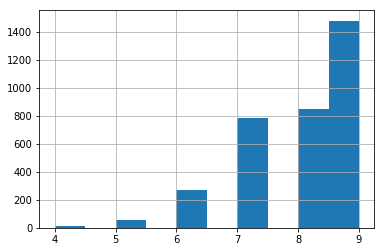

In [25]:
training_data_df[BEST_EPOCH].hist()

In [26]:
training_data_df[TOTAL_DURATION].describe()

count    3451.000000
mean      581.295856
std        91.205919
min       396.000000
25%       512.000000
50%       578.000000
75%       631.000000
max      1008.000000
Name: Total_Duration(s), dtype: float64

In [27]:
training_data_df.groupby([TRAINING_NUMBER]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
Training_Number,,,,,,,,
4,320.0,0.811348,0.007559,0.778397,0.806519,0.811439,0.815983,0.828518
0,400.0,0.811255,0.006998,0.787256,0.806774,0.812065,0.816543,0.825516
1,400.0,0.811156,0.007614,0.783002,0.805447,0.811063,0.817416,0.825660
2,400.0,0.811146,0.006390,0.789429,0.807340,0.811680,0.816097,0.824336
5,320.0,0.810656,0.008506,0.786631,0.804481,0.811533,0.816821,0.831003
3,331.0,0.809338,0.006545,0.784046,0.805171,0.809150,0.814077,0.828209
9,320.0,0.809211,0.007170,0.792208,0.804528,0.809050,0.813565,0.828776
6,320.0,0.809009,0.007943,0.782390,0.804060,0.809325,0.815190,0.826452
8,320.0,0.808279,0.007299,0.787330,0.803746,0.808127,0.813510,0.825289


In [28]:
rp.summary_cont(training_data_df[TEST_F1_MEASURE])

,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,Test_F1_Measure,3451.0,0.809954,0.007531,0.000128,0.809703,0.810205


In [29]:
rp.summary_cont(training_data_df.groupby(EMBEDDING))[TEST_F1_MEASURE]

,N,Mean,SD,SE,95% Conf.,Interval
Embedding,,,,,,
No,431,0.810019,0.007590,0.000366,0.809303,0.810736
fasttext,864,0.807166,0.007969,0.000271,0.806635,0.807698
glove,432,0.811875,0.006773,0.000326,0.811236,0.812513
wang2vec,862,0.811720,0.006766,0.000230,0.811269,0.812172
word2vec,862,0.809986,0.007303,0.000249,0.809499,0.810474


In [30]:
# Calculating effect size
def anova_table(aov):
    aov['mean_sq'] = aov[:]['sum_sq']/aov[:]['df']
    
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    
    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*aov['mean_sq'][-1]))/(sum(aov['sum_sq'])+aov['mean_sq'][-1])
    
    cols = ['sum_sq', 'mean_sq', 'df', 'F', 'PR(>F)', 'eta_sq', 'omega_sq']
    aov = aov[cols]
    return aov

def print_anova(parameter):
    # Fits the model with the interaction term
    # This will also automatically include the main effects for each factor
    model = ols('Test_F1_Measure ~ C({0})'.format(parameter), training_data_df).fit()
    # Seeing if the overall model is significant
    print(f"Overall model F({model.df_model: .0f},{model.df_resid: .0f}) = {model.fvalue: .3f}, p = {model.f_pvalue: .20f}")
    print(model.summary())
    res = sm.stats.anova_lm(model, typ= 2)
    print(res)
    print(anova_table(res))
    mc = statsmodels.stats.multicomp.MultiComparison(training_data_df[TEST_F1_MEASURE], training_data_df[parameter])
    mc_results = mc.tukeyhsd()
    print(mc_results)

In [31]:
print_anova(EMBEDDING)

Overall model F( 4, 3446) =  51.314, p =  0.00000000000000000000
                            OLS Regression Results                            
Dep. Variable:        Test_F1_Measure   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     51.31
Date:                Wed, 18 Sep 2019   Prob (F-statistic):           4.97e-42
Time:                        08:12:53   Log-Likelihood:                 12074.
No. Observations:                3451   AIC:                        -2.414e+04
Df Residuals:                    3446   BIC:                        -2.411e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------

In [32]:
training_data_df[(training_data_df.Embedding == 'wang2vec') & (training_data_df.Embedding_Type == 'skip') & (training_data_df.Representation == 'ELMo+Embeddings')]

,Training_ID,Model,Representation,Embedding,Embedding_Type,Training_Number,Execution_Number,Best_Epoch,Training_Epochs,Training_Duration,Total_Duration(s),Average_Epoch_Duration(s),Training_Accuracy,Training_Accuracy_Top-3,Training_Precision,Training_Recall,Training_F1-Measure,Training_Loss,Best_Validation_Accuracy,Best_Validation_Accuracy_Top-3,Best_Validation_Precision,Best_Validation_Recall,Best_Validation_F1-Measure,Best_Validation_Loss,Test_Accuracy,Test_Accuracy_Top-3,Test_Precision,Test_Recall,Test_F1_Measure,Test_Loss
538,harem-ft1epoch_ELMo+Embeddings_wang2vec_skip_0_1,harem-ft1epoch,ELMo+Embeddings,wang2vec,skip,0,1,8,10,0:07:59.563391,479.0,47.9,0.993316,0.993899,0.928065,0.918554,0.923285,59.097069,0.977926,0.980330,0.805897,0.836735,0.821026,186.269592,0.977291,0.979077,0.802213,0.798998,0.800602,229.160371
539,harem-ft1epoch_ELMo+Embeddings_wang2vec_skip_0_2,harem-ft1epoch,ELMo+Embeddings,wang2vec,skip,0,2,8,10,0:08:56.557806,536.0,53.6,0.993440,0.993999,0.927734,0.917476,0.922576,59.170702,0.979128,0.981423,0.804401,0.839286,0.821473,179.613590,0.977381,0.979197,0.806332,0.799332,0.802817,228.825894
540,harem-ft1epoch_ELMo+Embeddings_wang2vec_skip_0_3,harem-ft1epoch,ELMo+Embeddings,wang2vec,skip,0,3,8,10,0:10:30.035607,630.0,63.0,0.993719,0.994257,0.929915,0.919633,0.924746,58.516904,0.979019,0.981204,0.815271,0.844388,0.829574,183.602943,0.977366,0.979167,0.805995,0.798998,0.802482,231.091532
541,harem-ft1epoch_ELMo+Embeddings_wang2vec_skip_0_4,harem-ft1epoch,ELMo+Embeddings,wang2vec,skip,0,4,8,10,0:08:38.880011,518.0,51.8,0.993406,0.993988,0.926339,0.919094,0.922702,59.092602,0.978254,0.980658,0.809877,0.836735,0.823087,186.162399,0.977261,0.979092,0.802286,0.796661,0.799464,229.331091
542,harem-ft1epoch_ELMo+Embeddings_wang2vec_skip_1_0,harem-ft1epoch,ELMo+Embeddings,wang2vec,skip,1,0,8,10,0:09:10.339193,550.0,55.0,0.993894,0.994414,0.929501,0.922249,0.925861,58.648292,0.986258,0.987453,0.856423,0.887728,0.871795,133.558599,0.975760,0.977501,0.806901,0.812020,0.809452,246.304887
543,harem-ft1epoch_ELMo+Embeddings_wang2vec_skip_1_1,harem-ft1epoch,ELMo+Embeddings,wang2vec,skip,1,1,9,10,0:08:19.218081,499.0,49.9,0.993283,0.993860,0.923639,0.917676,0.920648,58.780010,0.987353,0.988449,0.864796,0.885117,0.874839,137.278025,0.978417,0.980158,0.822970,0.808681,0.815763,240.245235
544,harem-ft1epoch_ELMo+Embeddings_wang2vec_skip_1_2,harem-ft1epoch,ELMo+Embeddings,wang2vec,skip,1,2,9,10,0:09:35.900964,575.0,57.5,0.993690,0.994256,0.927913,0.921173,0.924531,59.061399,0.987552,0.988648,0.862595,0.885117,0.873711,137.825998,0.978552,0.980293,0.825467,0.811686,0.818519,244.555501
545,harem-ft1epoch_ELMo+Embeddings_wang2vec_skip_1_3,harem-ft1epoch,ELMo+Embeddings,wang2vec,skip,1,3,9,10,0:11:24.141196,684.0,68.4,0.993588,0.994142,0.926216,0.921980,0.924093,59.135724,0.987851,0.988946,0.869898,0.890339,0.880000,133.722347,0.977981,0.979797,0.827326,0.804674,0.815843,246.567333
546,harem-ft1epoch_ELMo+Embeddings_wang2vec_skip_1_4,harem-ft1epoch,ELMo+Embeddings,wang2vec,skip,1,4,9,10,0:09:15.624508,555.0,55.5,0.993396,0.994029,0.924513,0.919290,0.921894,58.281009,0.987652,0.988648,0.865482,0.890339,0.877735,139.050325,0.978206,0.979932,0.825289,0.810684,0.817922,245.614770
547,harem-ft1epoch_ELMo+Embeddings_wang2vec_skip_2_0,harem-ft1epoch,ELMo+Embeddings,wang2vec,skip,2,0,8,10,0:07:47.886636,467.0,46.7,0.993435,0.994003,0.921563,0.916230,0.918889,62.425644,0.981022,0.982076,0.825147,0.891720,0.857143,167.371662,0.976270,0.977981,0.806590,0.817362,0.811940,240.085055
